# Model Checking

After running an MCMC simulation, `sample` returns a `MultiTrace` object containing the samples for all the stochastic and deterministic random variables. The final step in Bayesian computation is model checking, in order to ensure that inferences derived from your sample are valid. There are two components to model checking:

1. Convergence diagnostics
2. Goodness of fit

Convergence diagnostics are intended to detect lack of convergence in the Markov chain Monte Carlo sample; it is used to ensure that you have not halted your sampling too early. However, a converged model is not guaranteed to be a good model. The second component of model checking, goodness of fit, is used to check the internal validity of the model, by comparing predictions from the model to the data used to fit the model. 

## Convergence Diagnostics

Valid inferences from sequences of MCMC samples are based on the
assumption that the samples are derived from the true posterior
distribution of interest. Theory guarantees this condition as the number
of iterations approaches infinity. It is important, therefore, to
determine the **minimum number of samples** required to ensure a reasonable
approximation to the target posterior density. Unfortunately, no
universal threshold exists across all problems, so convergence must be
assessed independently each time MCMC estimation is performed. The
procedures for verifying convergence are collectively known as
*convergence diagnostics*.

One approach to analyzing convergence is **analytical**, whereby the
variance of the sample at different sections of the chain are compared
to that of the limiting distribution. These methods use distance metrics
to analyze convergence, or place theoretical bounds on the sample
variance, and though they are promising, they are generally difficult to
use and are not prominent in the MCMC literature. More common is a
**statistical** approach to assessing convergence. With this approach,
rather than considering the properties of the theoretical target
distribution, only the statistical properties of the observed chain are
analyzed. Reliance on the sample alone restricts such convergence
criteria to **heuristics**. As a result, convergence cannot be guaranteed.
Although evidence for lack of convergence using statistical convergence
diagnostics will correctly imply lack of convergence in the chain, the
absence of such evidence will not *guarantee* convergence in the chain.
Nevertheless, negative results for one or more criteria may provide some
measure of assurance to users that their sample will provide valid
inferences.

For most simple models, convergence will occur quickly, sometimes within
a the first several hundred iterations, after which all remaining
samples of the chain may be used to calculate posterior quantities. For
more complex models, convergence requires a significantly longer burn-in
period; sometimes orders of magnitude more samples are needed.
Frequently, lack of convergence will be caused by **poor mixing**. 
Recall that *mixing* refers to the degree to which the Markov
chain explores the support of the posterior distribution. Poor mixing
may stem from inappropriate proposals (if one is using the
Metropolis-Hastings sampler) or from attempting to estimate models with
highly correlated variables.

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set_context('notebook')

In [2]:
from pymc3 import Normal, Binomial, sample, Model
from pymc3.math import invlogit

# Samples for each dose level
n = 5 * np.ones(4, dtype=int)
# Log-dose
dose = np.array([-.86, -.3, -.05, .73])
deaths = np.array([0, 1, 3, 5])

with Model() as bioassay_model:

    # Logit-linear model parameters
    alpha = Normal('alpha', 0, sd=100)
    beta = Normal('beta', 0, sd=100)

    # Calculate probabilities of death
    theta = invlogit(alpha + beta * dose)

    # Data likelihood
    obs_deaths = Binomial('obs_deaths', n=n, p=theta, observed=deaths)

In [7]:
with bioassay_model:
    bioassay_trace = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1250.24draws/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x786bb8173400>,
      dtype=object)

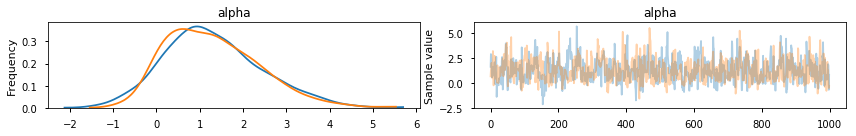

In [8]:
from pymc3 import traceplot

traceplot(bioassay_trace, varnames=['alpha'])

### Informal Methods

The most straightforward approach for assessing convergence is based on
simply **plotting and inspecting traces and histograms** of the observed
MCMC sample. If the trace of values for each of the stochastics exhibits
asymptotic behavior over the last $m$ iterations, this may be
satisfactory evidence for convergence. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x786bb8117550>,
      dtype=object)

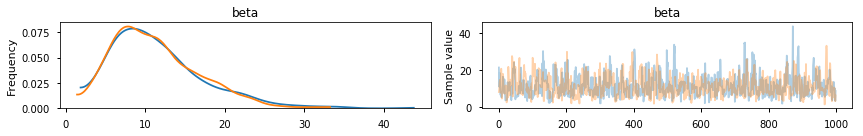

In [9]:
traceplot(bioassay_trace, varnames=['beta'])

A similar approach involves
plotting a histogram for every set of $k$ iterations (perhaps 50-100)
beyond some burn in threshold $n$; if the histograms are not visibly
different among the sample intervals, this may be considered some evidence for
convergence. Note that such diagnostics should be carried out for each
stochastic estimated by the MCMC algorithm, because convergent behavior
by one variable does not imply evidence for convergence for other
variables in the analysis. 

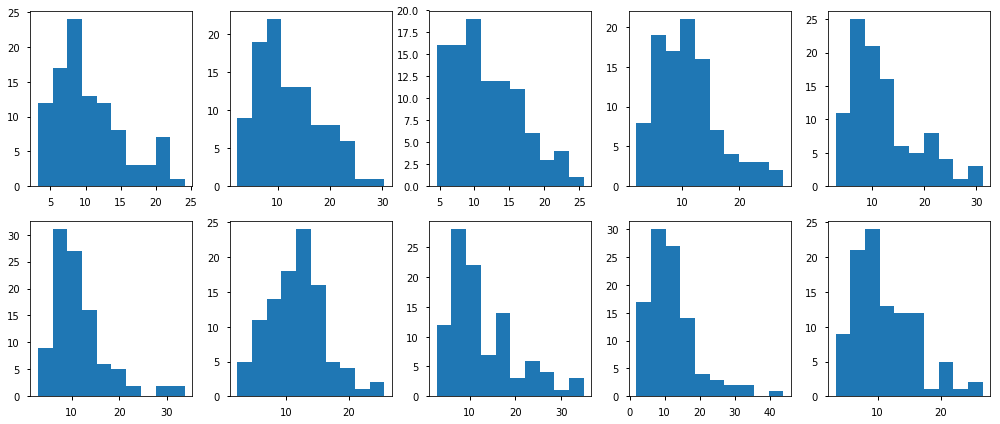

In [10]:
import matplotlib.pyplot as plt

beta_trace = bioassay_trace['beta']

fig, axes = plt.subplots(2, 5, figsize=(14,6))
axes = axes.ravel()
for i in range(10):
    axes[i].hist(beta_trace[100*i:100*(i+1)])
plt.tight_layout()

An extension of this approach can be taken
when multiple parallel chains are run, rather than just a single, long
chain. In this case, the final values of $c$ chains run for $n$
iterations are plotted in a histogram; just as above, this is repeated
every $k$ iterations thereafter, and the histograms of the endpoints are
plotted again and compared to the previous histogram. This is repeated
until consecutive histograms are indistinguishable.

Another *ad hoc* method for detecting lack of convergence is to examine
the traces of several MCMC chains initialized with different starting
values. Overlaying these traces on the same set of axes should (if
convergence has occurred) show each chain tending toward the same
equilibrium value, with approximately the same variance. Recall that the
tendency for some Markov chains to converge to the true (unknown) value
from diverse initial values is called *ergodicity*. This property is
guaranteed by the reversible chains constructed using MCMC, and should
be observable using this technique. Again, however, this approach is
only a heuristic method, and cannot always detect lack of convergence,
even though chains may appear ergodic.

In [11]:
with bioassay_model:
    
    bioassay_trace = sample(1000, chains=2, start=[{'alpha':0.5}, {'alpha':5}])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1104.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [12]:
bioassay_trace.get_values('alpha', chains=0)[0]

0.10510441800852766

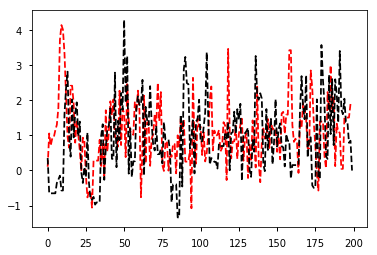

In [13]:
plt.plot(bioassay_trace.get_values('alpha', chains=0)[:200], 'r--')
plt.plot(bioassay_trace.get_values('alpha', chains=1)[:200], 'k--')

A principal reason that evidence from informal techniques cannot
guarantee convergence is a phenomenon called ***metastability***. Chains may
appear to have converged to the true equilibrium value, displaying
excellent qualities by any of the methods described above. However,
after some period of stability around this value, the chain may suddenly
move to another region of the parameter space. This period
of metastability can sometimes be very long, and therefore escape
detection by these convergence diagnostics. Unfortunately, there is no
statistical technique available for detecting metastability.

### Formal Methods

Along with the *ad hoc* techniques described above, a number of more
formal methods exist which are prevalent in the literature. These are
considered more formal because they are based on existing statistical
methods, such as time series analysis.

PyMC currently includes three formal convergence diagnostic methods. The
first, proposed by [Geweke (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011446), is a time-series approach that
compares the mean and variance of segments from the beginning and end of
a single chain.

$$z = \frac{\bar{\theta}_a - \bar{\theta}_b}{\sqrt{S_a(0) + S_b(0)}}$$

where $a$ is the early interval and $b$ the late interval, and $S_i(0)$ is the spectral density estimate at zero frequency for chain segment $i$. If the
z-scores (theoretically distributed as standard normal variates) of
these two segments are similar, it can provide evidence for convergence.
PyMC calculates z-scores of the difference between various initial
segments along the chain, and the last 50% of the remaining chain. If
the chain has converged, the majority of points should fall within 2
standard deviations of zero.

In PyMC, diagnostic z-scores can be obtained by calling the `geweke` function. It
accepts either (1) a single trace, (2) a Node or Stochastic object, or
(4) an entire Model object:

In [16]:
from pymc3 import geweke

with bioassay_model:
    tr = sample(2000, tune=1000)
    
z = geweke(tr, intervals=15)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1253.53draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


(0, 1000)

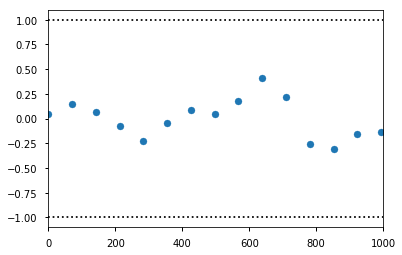

In [17]:
plt.scatter(*z[0]['alpha'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

The arguments expected are the following:

- `x` : The trace of a variable.
- `first` : The fraction of series at the beginning of the trace.
- `last` : The fraction of series at the end to be compared with the section at the beginning.
- `intervals` : The number of segments.

Plotting the output displays the scores in series, making it is easy to
see departures from the standard normal assumption.

A second convergence diagnostic provided by PyMC is the Gelman-Rubin
statistic [Gelman and Rubin (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011136). This diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

The Gelman-Rubin diagnostic uses an analysis of variance approach to
assessing convergence. That is, it calculates both the between-chain
varaince (B) and within-chain varaince (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, the Gelman-Rubin statistic monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the potential scale reduction, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. In PyMC, the function
`gelman_rubin` will calculate $\hat{R}$ for each stochastic node in
the passed model:

In [18]:
from pymc3 import gelman_rubin

gelman_rubin(bioassay_trace)

{'alpha': 1.0051464094792733, 'beta': 1.0008357886290746}

For the best results, each chain should be initialized to highly
dispersed starting values for each stochastic node.

By default, when calling the `forestplot` function using nodes with
multiple chains, the $\hat{R}$ values will be plotted alongside the
posterior intervals.

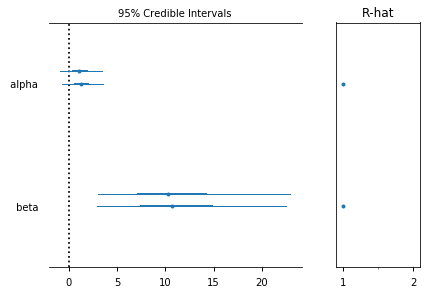

In [19]:
from pymc3 import forestplot

forestplot(bioassay_trace)

## Autocorrelation

In general, samples drawn from MCMC algorithms will be autocorrelated. This is not a big deal, other than the fact that autocorrelated chains may require longer sampling in order to adequately characterize posterior quantities of interest. The calculation of autocorrelation is performed for each lag $i=1,2,\ldots,k$ (the correlation at lag 0 is, of course, 1) by: 

$$\hat{\rho}_i = 1 - \frac{V_i}{2\hat{\text{Var}}(\theta | y)}$$

where $\hat{\text{Var}}(\theta | y)$ is the same estimated variance as calculated for the Gelman-Rubin statistic, and $V_i$ is the variogram at lag $i$ for $\theta$:

$$\text{V}_i = \frac{1}{m(n-i)}\sum_{j=1}^m \sum_{k=i+1}^n (\theta_{jk} - \theta_{j(k-i)})^2$$

This autocorrelation can be visualized using the `autocorrplot` function in PyMC3:

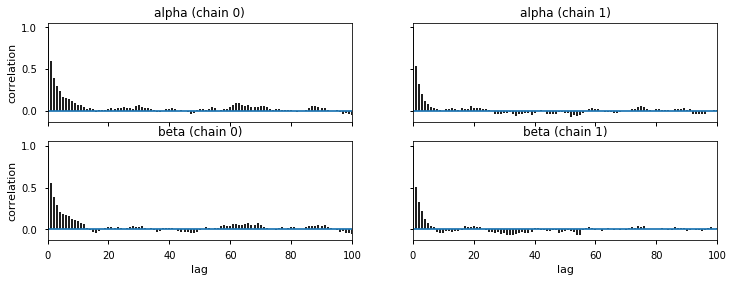

In [20]:
from pymc3 import autocorrplot

autocorrplot(tr);

### Effective sample size

The effective sample size is estimated using the partial sum:

$$\hat{n}_{eff} = \frac{mn}{1 + 2\sum_{i=1}^T \hat{\rho}_i}$$

where $T$ is the first odd integer such that $\hat{\rho}_{T+1} + \hat{\rho}_{T+2}$ is negative.

The issue here is related to the fact that we are **estimating** the effective sample size from the fit output. Values of $n_{eff} / n_{iter} < 0.001$ indicate a biased estimator, resulting in an overestimate of the true effective sample size.

In [21]:
from pymc3 import effective_n

effective_n(bioassay_trace)

{'alpha': 515.0238334475029, 'beta': 479.8126544482517}

Both low $n_{eff}$ and high $\hat{R}$ indicate **poor mixing**.

It is tempting to want to **thin** the chain to eliminate the autocorrelation (*e.g.* taking every 20th sample from the traces above), but this is a waste of time. Since thinning deliberately throws out the majority of the samples, no efficiency is gained; you ultimately require more samples to achive a particular desired sample size. 

## Diagnostics for Gradient-based Samplers

Hamiltonian Monte Carlo is a powerful and efficient MCMC sampler when set up appropriately. However, this typically requires carefull tuning of the sampler parameters, such as tree depth, leapfrog step size and target acceptance rate. Fortunately, the NUTS algorithm takes care of some of this for us. Nevertheless, tuning must be carefully monitored for failures that frequently arise. This is particularly the case when fitting challenging models, such as those with high curvature or heavy tails.

Fortunately, however, gradient-based sampling provides the ability to diagnose these pathologies. PyMC makes several diagnostic statistics available as attributes of the `MultiTrace` object returned by the `sample` function.

In [22]:
bioassay_trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

- `mean_tree_accept`: The mean acceptance probability for the tree that generated this sample. The mean of these values across all samples but the burn-in should be approximately `target_accept` (the default for this is 0.8).
- `diverging`: Whether the trajectory for this sample diverged. If there are many diverging samples, this usually indicates that a region of the posterior has high curvature. Reparametrization can often help, but you can also try to increase `target_accept` to something like 0.9 or 0.95.
- `energy`: The energy at the point in phase-space where the sample was accepted. This can be used to identify posteriors with problematically long tails. See below for an example.
- `energy_error`: The difference in energy between the start and the end of the trajectory. For a perfect integrator this would always be zero.
- `max_energy_error`: The maximum difference in energy along the whole trajectory.
- `depth`: The depth of the tree that was used to generate this sample
- `tree_size`: The number of leafs of the sampling tree, when the sample was accepted. This is usually a bit less than $2 ^ \text{depth}$. If the tree size is large, the sampler is using a lot of leapfrog steps to find the next sample. This can for example happen if there are strong correlations in the posterior, if the posterior has long tails, if there are regions of high curvature ("funnels"), or if the variance estimates in the mass matrix are inaccurate. Reparametrisation of the model or estimating the posterior variances from past samples might help.
- `tune`: This is `True`, if step size adaptation was turned on when this sample was generated.
- `step_size`: The step size used for this sample.
- `step_size_bar`: The current best known step-size. After the tuning samples, the step size is set to this value. This should converge during tuning.

If the name of the statistic does not clash with the name of one of the variables, we can use indexing to get the values. The values for the chains will be concatenated.

We can see that the step sizes converged after the 2000 tuning samples for both chains to about the same value. The first 3000 values are from chain 1, the second from chain 2.

In [23]:
with bioassay_model:
    trace = sample(1000, tune=2000, init=None, chains=2, discard_tuned_samples=False)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1196.83draws/s]
The number of effective samples is smaller than 25% for some parameters.


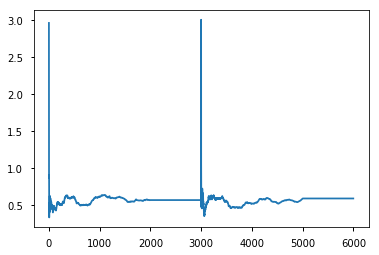

In [24]:
plt.plot(trace['step_size_bar'])

The `get_sampler_stats` method provides more control over which values should be returned, and it also works if the name of the statistic is the same as the name of one of the variables. We can use the `chains` option, to control values from which chain should be returned, or we can set `combine=False` to get the values for the individual chains:

The `NUTS` step method has a maximum tree depth parameter so that infinite loops (which can occur for non-identified models) are avoided. When the maximum tree depth is reached (the default value is 10), the trajectory is stopped. However complex (but identifiable) models can saturate this threshold, which reduces sampling efficiency.

The `MultiTrace` stores the tree depth for each iteration, so inspecting these traces can reveal saturation if it is occurring.

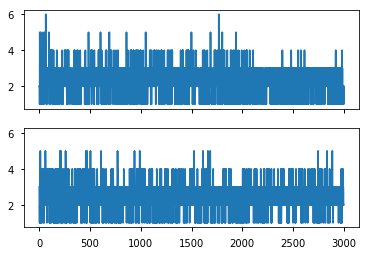

In [25]:
sizes1, sizes2 = trace.get_sampler_stats('depth', combine=False)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.plot(sizes1)
ax2.plot(sizes2)

We can also check the acceptance for the trees that generated this sample. The mean of these values across all samples (except the tuning stage) is expected to be the same as `target_accept`, which is 0.8 by default.

/home/fonnesbeck/anaconda3/envs/dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


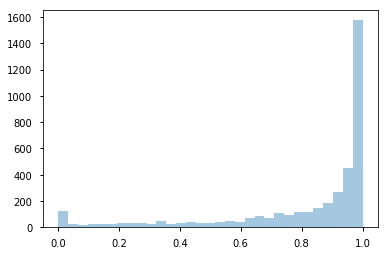

In [26]:
accept = trace.get_sampler_stats('mean_tree_accept', burn=1000)
sns.distplot(accept, kde=False)

### Divergent transitions

Recall that simulating Hamiltonian dynamics via a symplectic integrator uses a discrete approximation of a continuous function. This is only a reasonable approximation when the step sizes of the integrator are suitably small. A divergent transition may indicate that the approximation is poor.

If there are too many divergent transitions, then samples are not being drawn from the full posterior, and inferences based on the resulting sample will be biased

If there are diverging transitions, PyMC3 will issue warnings indicating how many were discovered. We can obtain the indices of them from the trace.

In [27]:
trace['diverging'].nonzero()

(array([   1,   72,  101,  185, 1571, 1622, 1687, 3246, 3688, 3727]),)

### Bayesian Fraction of Missing Information

The Bayesian fraction of missing information (BFMI) is a measure of how hard it is to
sample level sets of the posterior at each iteration. Specifically, it quantifies how well momentum resampling matches the marginal energy distribution. A small value indicates that the adaptation phase of the sampler was unsuccessful, and invoking the central limit theorem may not be valid. It indicates whether the sampler is able to adequately explore the posterior distribution.

Though there is not an established rule of thumb for an adequate threshold, values close to one are optimal. Reparameterizing the model is sometimes helpful for improving this statistic.

In [28]:
from pymc3 import bfmi

In [29]:
bfmi(trace)

0.9736023215435101

Another way of diagnosting this phenomenon is by comparing the overall distribution of 
energy levels with the *change* of energy between successive samples. Ideally, they should be very similar.

If the distribution of energy transitions is narrow relative to the marginal energy distribution, this is a sign of inefficient sampling, as many transitions are required to completely explore the posterior. On the other hand, if the energy transition distribution is similar to that of the marginal energy, this is evidence of efficient sampling, resulting in near-independent samples from the posterior.

/home/fonnesbeck/anaconda3/envs/dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fonnesbeck/anaconda3/envs/dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


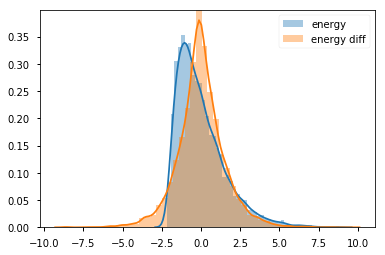

In [33]:
energy = trace['energy']
energy_diff = np.diff(energy)
sns.distplot(energy - energy.mean(), label='energy')
sns.distplot(energy_diff, label='energy diff')
plt.legend()

If the overall distribution of energy levels has longer tails, the efficiency of the sampler will deteriorate quickly.

## Goodness of Fit

Checking for model convergence is only the first step in the evaluation
of MCMC model outputs. It is possible for an entirely unsuitable model
to converge, so additional steps are needed to ensure that the estimated
model adequately fits the data. One intuitive way of evaluating model
fit is to compare model predictions with the observations used to fit
the model. In other words, the fitted model can be used to simulate
data, and the distribution of the simulated data should resemble the
distribution of the actual data.

Fortunately, simulating data from the model is a natural component of
the Bayesian modelling framework. Recall, from the discussion on
imputation of missing data, the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be
expected, taking into account the posterior uncertainty in the model
parameters. 

Sampling from the posterior predictive distribution is easy
in PyMC. The `sample_ppc` function draws posterior predictive checks from all of the data likelhioods. Consider the `gelman_bioassay` example, 
where deaths are modeled as a binomial random variable for which
the probability of death is a logit-linear function of the dose of a
particular drug.

The posterior predictive distribution of deaths uses the same functional
form as the data likelihood, in this case a binomial stochastic. Here is
the corresponding sample from the posterior predictive distribution (we typically need very few samples relative to the MCMC sample):

In [34]:
from pymc3 import sample_ppc

with bioassay_model:
    deaths_sim = sample_ppc(bioassay_trace, samples=500)

100%|██████████| 500/500 [00:00<00:00, 1779.19it/s]


The degree to which simulated data correspond to observations can be evaluated in at least two ways. First, these quantities can simply be compared visually. This allows for a qualitative comparison of model-based replicates and observations. If there is poor fit, the true value of the data may appear in the tails of the histogram of replicated data, while a good fit will tend to show the true data in high-probability regions of the posterior predictive distribution. The Matplot package in PyMC provides an easy way of producing such plots, via the `gof_plot` function.

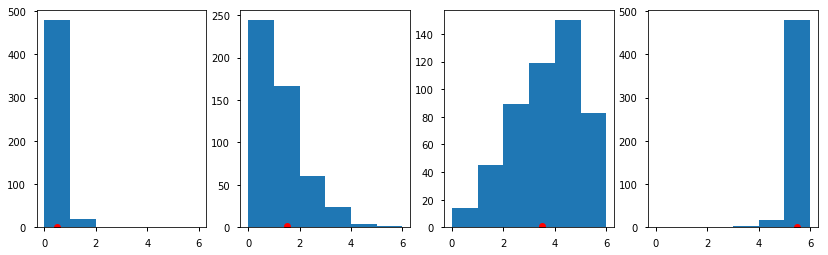

In [35]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

for obs, sim, ax in zip(deaths, deaths_sim['obs_deaths'].T, axes):
    ax.hist(sim, bins=range(7))
    ax.plot(obs+0.5, 1, 'ro')

## Exercise: Meta-analysis of beta blocker effectiveness

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction.

In a random effects meta-analysis we assume the true effect (on a log-odds scale) $d_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$,
and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta_i \\
\delta_i &\sim \text{Normal}(d, t) \\
\mu_i &\sim \text{Normal}(m, s)
\end{aligned}$$

We want to make inferences about the population effect $d$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. Build a model to estimate these quantities in PyMC, and (1) use convergence diagnostics to check for convergence and (2) use posterior predictive checks to assess goodness-of-fit.

Here are the data:

In [29]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 
           25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 
           291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 
           31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 
           293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

In [30]:
# Write your answer here

## References

Gelman, A., & Rubin, D. B. (1992). Inference from iterative simulation using multiple sequences. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 457–472.

Geweke, J., Berger, J. O., & Dawid, A. P. (1992). Evaluating the accuracy of sampling-based approaches to the calculation of posterior moments. In Bayesian Statistics 4.

Brooks, S. P., Catchpole, E. A., & Morgan, B. J. T. (2000). Bayesian Animal Survival Estimation. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 15(4), 357–376. doi:10.1214/ss/1177010123

Gelman, A., Meng, X., & Stern, H. (1996). Posterior predicitive assessment of model fitness via realized discrepencies with discussion. Statistica Sinica, 6, 733–807.

Betancourt, M. (2017). A Conceptual Introduction to Hamiltonian Monte Carlo. arXiv.org.